# BONUS
We will try to find evidence of global warming in our data.



In [19]:
import findspark

findspark.init()
import os
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [20]:
os.environ[
    'PYSPARK_SUBMIT_ARGS'] = "--packages=org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.4,"\
                             "com.microsoft.azure:spark-mssql-connector:1.0.2 pyspark-shell"


Start our spark session and define out global parameters

In [21]:
def init_spark(app_name):
    spark = SparkSession.builder.appName(app_name).getOrCreate()
    sc = spark.sparkContext
    return spark, sc


server_name = "ServerName"
database_name = "DatabaseName"
url = server_name + ";" + "databaseName=" + database_name + ";"
table_name = "TableName"
username = "Username"
password = "Password"
spark, sc = init_spark('Project')
kafka_server = 'dds2020s-kafka.eastus.cloudapp.azure.com:9092'

We will now load our data from the data store into a Pyspark Dataframes.

In [24]:
jdbcDF = spark.read\
    .format("jdbc")\
    .option("url", url)\
    .option("dbtable", table_name)\
    .option("user", username)\
    .option("password", password).load()
jdbcDF.createOrReplaceTempView("DataStore_Stage2")

jdbcDF = spark.sql(
    """select d1.Year_Rec,d1.Month_Rec,avg(d1.TMAX) TMAX,avg(d1.TMIN) TMIN
        from DataStore_Stage2 d1
        group by d1.Year_Rec, d1.Month_Rec
        """)

Load training data

In [25]:
tmax = jdbcDF.select('Year_Rec', 'TMAX').dropna(how='any')
tmin = jdbcDF.select('Year_Rec', 'TMIN').dropna(how='any')
assembler = VectorAssembler(inputCols=['Year_Rec'], outputCol="features")

tmax_output = assembler.transform(tmax).drop("Year_Rec") \
    .withColumn("label", F.col("TMAX")).drop("TMAX")

tmin_output = assembler.transform(tmin).drop("Year_Rec") \
    .withColumn("label", F.col("TMIN")).drop("TMIN")

(trainingData_tmax, testData_tmax) = tmax_output.randomSplit([0.7, 0.3])
(trainingData_tmin, testData_tmin) = tmin_output.randomSplit([0.7, 0.3])

Fit the model

In [26]:
glr_tmax = LinearRegression(maxIter=10, regParam=0.3)
glr_tmin = LinearRegression(maxIter=10, regParam=0.3)
tmax_model = glr_tmax.fit(trainingData_tmax)
tmin_model = glr_tmin.fit(trainingData_tmin)

Print the coefficients for the linear regression model

In [27]:
print("TMAX - Slope: " + str(tmax_model.coefficients[0])+", Intercept: "+ str(tmax_model.intercept))
print("TMIN - Slope: " + str(tmin_model.coefficients[0])+", Intercept: "+ str(tmin_model.intercept))

TMAX - Slope: 0.013724400295961512, Intercept: -15.920411330658862
TMIN - Slope: 0.01488011713226868, Intercept: -26.493090758972276


Summarize the model over the training set

In [28]:
summary = tmax_model.summary
print("TMAX")
tmax_slope, tmax_intercept =summary.coefficientStandardErrors
print("\tCoefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print()

print("TMIN")
summary = tmin_model.summary
tmin_slope, tmin_intercept =summary.coefficientStandardErrors
print("\tCoefficient Standard Errors: " + str(summary.coefficientStandardErrors))

TMAX
	Coefficient Standard Errors: [0.0068289124971494565, 13.385502451120963]

TMIN
	Coefficient Standard Errors: [0.005345169428535969, 10.476158305228882]


In [29]:
tmax_predictions = tmax_model.transform(testData_tmax)
tmin_predictions = tmin_model.transform(testData_tmin)

tmax_predictions.select("prediction", "label", "features").show(5)
tmin_predictions.select("prediction", "label", "features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

tmax_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")
print("R Squared (R2) on test data = %g" % tmax_evaluator.evaluate(tmax_predictions))
tmin_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")
print("R Squared (R2) on test data = %g" % tmin_evaluator.evaluate(tmin_predictions))



+------------------+------------------+--------+
|        prediction|             label|features|
+------------------+------------------+--------+
|10.471610438475125|21.892188241865657|[1923.0]|
|10.553956840250894|19.979646697388638|[1929.0]|
|10.787271645282239| 22.87394424467177|[1946.0]|
|10.910791247945895|18.825878345489055|[1955.0]|
|11.020586450313587| 4.061338123797829|[1963.0]|
+------------------+------------------+--------+
only showing top 5 rows

+------------------+--------------------+--------+
|        prediction|               label|features|
+------------------+--------------------+--------+
|2.1213744863803967|  11.732085745795423|[1923.0]|
|3.2225031541682796|-0.49540387807223885|[1997.0]|
|2.9249008115229067|    4.70122823866002|[1977.0]|
| 2.969541162919711|  11.406262434046539|[1980.0]|
|3.2373832713005477| -2.0989058143434973|[1998.0]|
+------------------+--------------------+--------+
only showing top 5 rows

R Squared (R2) on test data = 0.00653426
R Squared

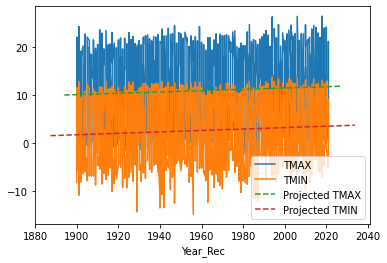

In [30]:
import matplotlib.pyplot as plt
import numpy as np
def abline(slope, intercept, label):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label=label)


ax = tmax.toPandas().sort_values("Year_Rec").plot(x='Year_Rec', y='TMAX')
tmin.toPandas().sort_values("Year_Rec").plot(x='Year_Rec', y='TMIN', ax=ax)
abline(tmax_model.coefficients[0],tmax_model.intercept, label="Projected TMAX")
abline(tmin_model.coefficients[0], tmin_model.intercept, label="Projected TMIN")
plt.legend()
plt.show()


We can see that both lines fitted to the data have a positive slope coefficient, indicating a rise in temperatures.<br>
The slope of the maximum temperatures is ~0.014, indicating that the average maximum temperature will rise by 1 degree Celsius every 71.5 years.<br>
In addition, the slope of the maximum temperatures is ~0.015, and the minimum temperatures will rise by 1 degree Celsius every 66.6 years. <br>
To conclude, global warming is evident in our data.
